In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go


In [262]:
pd.set_option("display.max_columns", 0)
pd.set_option("display.max_colwidth", 0)

In [269]:
results_history = pd.DataFrame({'accuracy': [], 'precision': [], 'recall': [
], 'config': [], 'algorithm': [], 'params': []})

In [3]:
data_sheet = pd.read_csv("agency_data_en.csv")

In [4]:
data_sheet.head()

,Textstring,label,Domain,language
0,skip to content toggle navigation ...,True,http://cleverreach.com,en
1,safedome home products popular products rechar...,True,http://maxwellforest.com,en
2,skip to main navigation logo ...,True,http://spark.net,en
3,top sign in creat...,True,http://ab.com,en
4,skip main navigation menu marri...,True,http://marriot.com,en


In [5]:
data_sheet.shape

(1613, 4)

# Split dataset

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    data_sheet['Textstring'], data_sheet['label'], test_size=0.3, random_state=1)

In [96]:
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.33, random_state=1)

In [97]:
X_train = X_train.tolist()
X_val = X_val.tolist()
X_test = X_test.tolist()
y_train = np.asarray(y_train.tolist(), dtype=np.uint8)
y_val = np.asarray(y_val.tolist(), dtype=np.uint8)
y_test = np.asarray(y_test.tolist(), dtype=np.uint8)

## Check label distribution

In [98]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=y_train,
    histnorm='percent',
    name='train_set', # name used in legend and hover labels
    marker_color='#EB89B5',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=y_val,
    histnorm='percent',
    name='val_set', # name used in legend and hover labels
    marker_color='#330C73',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=y_test,
    histnorm='percent',
    name='test_set', # name used in legend and hover labels
    marker_color='#AABBCC',
    opacity=0.75
))

fig.update_layout(
    title_text='Sampled Results', # title of plot
    xaxis_title_text='Value', # xaxis label
    yaxis_title_text='Percentage', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

In [99]:
fig = go.Figure([go.Bar(x=['train', 'val', 'test'], y=[len(y_train), len(y_val), len(y_test)])])
fig.show()

# Tokenize vectors

## Look for keywords

In [100]:
import json
import numpy as np

In [101]:
with open('keywords.json', 'r') as f:
    keywords = json.load(f)

In [102]:
def create_vector(textstring, keywords):
    vector = np.zeros(len(keywords), dtype=np.uint8)
    for k, keyword in enumerate(keywords):
        if keyword in textstring:
            vector[k] = 1
    return vector

def create_vectors(textstrings, feature_vec, keywords):
    for t, textstring in enumerate(textstrings):
        feature_vec[t] = create_vector(textstring, keywords)
    return feature_vec

In [103]:
X_train_f = np.zeros((len(X_train), len(keywords)), dtype=np.uint8)
X_val_f = np.zeros((len(X_val), len(keywords)), dtype=np.uint8)
X_test_f = np.zeros((len(X_test), len(keywords)), dtype=np.uint8)

In [104]:
X_train_f = create_vectors(X_train, X_train_f, keywords)
X_val_f = create_vectors(X_val, X_val_f, keywords)
X_test_f = create_vectors(X_test, X_test_f, keywords)

We want to know how predictive the presence or absence of keywords are.

In [105]:
correlation_mat_train = np.zeros((2,2, len(keywords)), dtype=np.int)

In [106]:
for i, x in enumerate(X_train_f):
    label = y_train[i]
    for k in range(len(x)):
        correlation_mat_train[label, x[k], k] += 1

In [124]:
keywords_annot = [[keyword, keyword] for keyword in keywords]
keywords_annot = sum(keywords_annot,[])

In [165]:
x = [
    keywords_annot, ["NA/P", "A/P"]*len(keywords)
]
fig = go.Figure()
fig.add_bar(x=x,y=correlation_mat_train[:, 1, :].flatten('F'))
fig.update_layout(barmode="relative", xaxis_tickangle=90)
fig.update_xaxes(tickangle=90)
fig.show()

## Choose specific keywords

In [301]:
keywords_choice = keywords[-9:]

In [302]:
keywords_index = [keywords.index(k) for k in keywords_choice]

In [303]:
X_train_f_c = X_train_f[:, keywords_index]
X_val_f_c = X_val_f[:, keywords_index]

## Train a classifier

In [304]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, recall_score, precision_score

In [312]:
algorithm = 'RF'
params = {'max_depth': 5, 'random_state':0}

In [306]:
if algorithm == 'RF':
    clf = RandomForestClassifier(max_depth=5, random_state=0)
    clf.fit(X_train_f_c, y_train)

# Evaluation

In [307]:
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [308]:
predicted_val = clf.predict(X_val_f_c)

## General Metrics

In [309]:
accuracy = accuracy_score(predicted_val, y_val)
precision = precision_score(predicted_val, y_val)
recall = recall_score(predicted_val, y_val)

In [310]:
results_history = results_history.append({'accuracy': accuracy, 'precision': precision,
                        'recall': recall, 'config': keywords_choice, 
                                         'algorithm': algorithm, 'params': params}, ignore_index=True)

In [311]:
results_history

,accuracy,precision,recall,config,algorithm,params
0,0.697531,0.576389,0.691667,"[brand, branding, design, creative, strategy, marketing, consumer, client, agency]",RF,"{'max_depth': 5, 'random_state': 0}"
1,0.694444,0.569444,0.689076,"[brand, branding, design, creative, strategy, marketing, consumer, client, agency, brand agency]",RF,"{'max_depth': 5, 'random_state': 0}"
2,0.697531,0.576389,0.691667,"[brand, branding, design, creative, strategy, marketing, consumer, client, agency]",RF,"{'max_depth': 7, 'random_state': 0}"


In [313]:
print('Accuracy: %.2f'%accuracy)
print('Precision: %.2f'%precision)
print('Recall: %.2f'%recall)

Accuracy: 0.70
Precision: 0.58
Recall: 0.69


## Plots

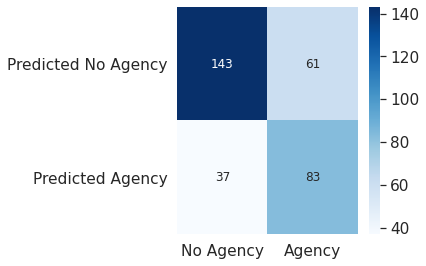

In [314]:
conf_mat = confusion_matrix(predicted_val, y_val)
df_cm = pd.DataFrame(conf_mat, ['Predicted No Agency', 'Predicted Agency'], ['No Agency', 'Agency'])
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, cmap='Blues', annot=True,
           annot_kws={"size": 12}, fmt='g')  # font size
plt.tight_layout()
plt.show()